In [1]:
# Install dependencies.
!rm -r sample_data
!pip install -qq --upgrade transformers compel accelerate diffusers
from IPython.display import clear_output
clear_output()

In [ ]:
# Set the details for your model here:
import torch

from diffusers import AutoencoderKL, StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline

use_refiner = True

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    add_watermarker=False
).to("cuda")

if use_refiner:
  refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
      vae=vae,
      text_encoder_2=base.text_encoder_2,
      torch_dtype=torch.float16,
      variant="fp16",
      use_safetensors=True,
      add_watermarker=False
  ).to("cuda")
clear_output()

In [ ]:
torch.cuda.empty_cache()

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

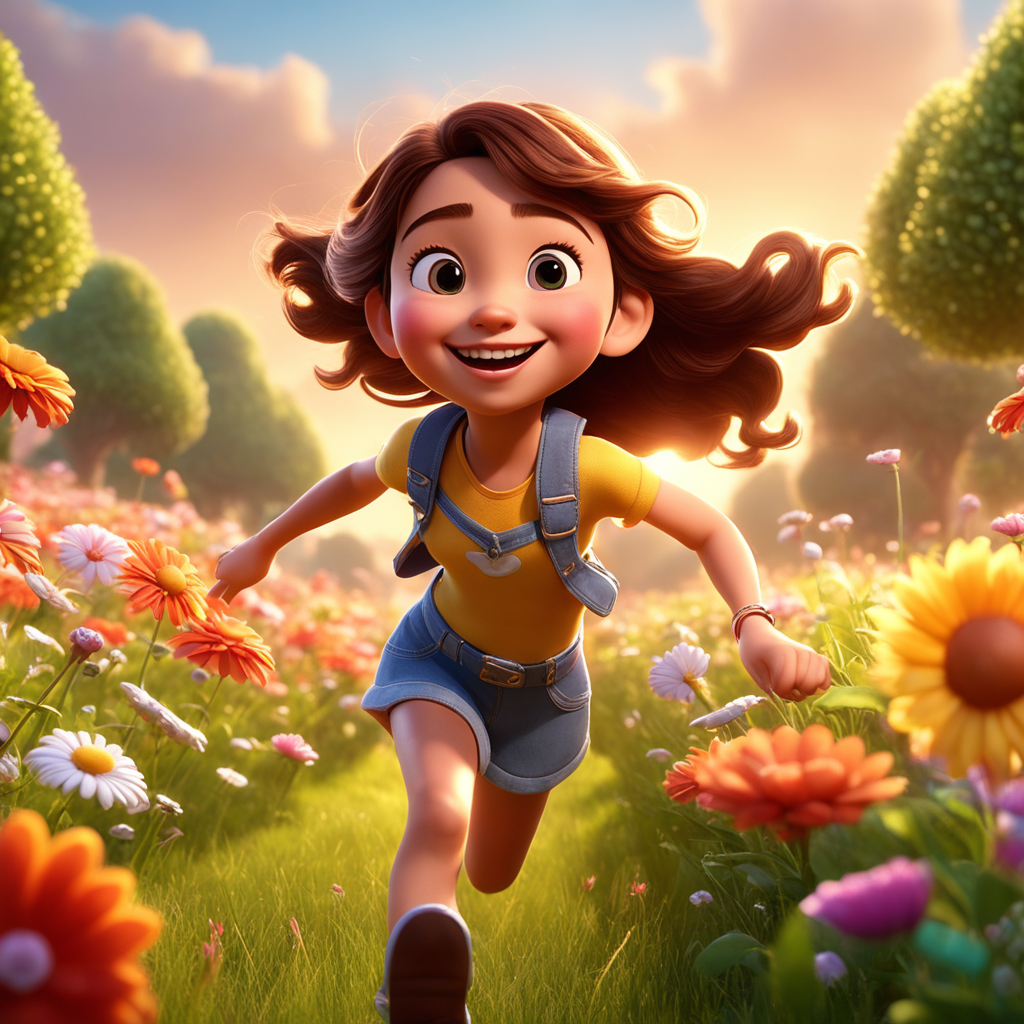

In [ ]:
negative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
prompt = "close up Photograph of woman in red dress in a luxury garden surrounded with blue, yellow, purple and flowers in many colors, high class, award-winning photography, Portra 400, full format"
prompt = "Cute girl with cool outfit, happily running on the beautiful flowery meadow, disney pixar, volumetric lighting"
prompt += "intricate details, extreme detail of the environment, sharp portrait, well lit, interesting clothes,radial gradient fade directional particle lighting, subsurface scattering, ambient occlusion, neighborhood average tonal shading, bright, ultra realistic"

def clear_outliers(tensor, strength=20, method="mean"):
    axis = (2, 3)

    mean = tensor.mean(axis, keepdim=True).expand_as(tensor)
    std = tensor.std(axis, keepdim=True).expand_as(tensor)

    z_score = 4.1-strength*0.025

    if method=="mean":
        return torch.where((tensor < mean - z_score * std) | (tensor > mean + z_score * std), mean, tensor)
    elif method=="threshold":
        outliers = torch.abs(tensor - mean) > z_score * std
        shift = z_score * std[outliers]
        tensor[outliers] = torch.where(tensor[outliers] > mean[outliers], mean[outliers] + shift, mean[outliers] - shift)
    return tensor

def maximize_tensor(tensor, strength):
    initial_boundary = max(abs(tensor.min()), abs(tensor.max()))
    new_boundary = initial_boundary + (3.83877 - initial_boundary) * strength / 100

    normalization_factor = new_boundary / initial_boundary

    return tensor * normalization_factor

def center_shift_tensor(tensor, channel_shift=1, full_shift=1, channels=[0, 1, 2, 3]):
    for channel in channels:
        tensor[0, channel] -= tensor[0, channel].mean() * channel_shift
    return tensor - tensor.mean() * full_shift

def callback(pipe, step_index, timestep, cbk):
    boundary = max(abs(cbk["latents"].min()), abs(cbk["latents"].max()))
    if step_index == 0:
        cbk["latents"] = center_shift_tensor(cbk["latents"], channel_shift=0.01*shift_strength, full_shift=0.01*shift_strength)
    if step_index < 5:
      cbk["latents"] = clear_outliers(cbk["latents"], strength=clear_outliers_strength, method=clear_outliers_method)
    elif timestep > 700:
        cbk["latents"] = center_shift_tensor(cbk["latents"], channel_shift=0.008*shift_strength, full_shift=0.01*shift_strength)
    if timestep > 200 and timestep < 300:
        cbk["latents"] = center_shift_tensor(cbk["latents"], channel_shift=0.004*shift_strength, full_shift=0.005*shift_strength, channels=[0, 1, 2])
    if timestep == 1:
        cbk["latents"] = maximize_tensor(cbk["latents"], strength=maximize_strength)
    return cbk

num_inference_steps = 30
guidance_scale = 20
maximize_strength = 100
shift_strength = 0
clear_outliers_strength = 0
clear_outliers_method = "threshold"
base_seed = 3
base_generator = torch.Generator()
base_generator.manual_seed(base_seed)
if use_refiner:
  refiner_generator = torch.Generator()
  refiner_generator.manual_seed(base_seed ^ 0xffffffff)

image = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, guidance_scale = guidance_scale, callback_on_step_end=callback, callback_on_step_end_inputs=["latents"], generator=base_generator, denoising_end=0.8 if use_refiner else 1.0, output_type="latent" if use_refiner else "pil").images
if use_refiner:
  image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=int(num_inference_steps*1.5), callback_on_step_end=callback, callback_on_step_end_inputs=["latents"], generator=refiner_generator, denoising_start=0.8, image=image).images
display(image[0])

for maximize_strength in range(0, 101, 10):
  for shift_strength in range(0, 101, 10):
    for clear_outliers_strength in range(0, 101, 10):
      print(clear_outliers_strength, shift_strength, maximize_strength)
      base_seed = 3
      base_generator = torch.Generator()
      base_generator.manual_seed(base_seed)
      if use_refiner:
        refiner_generator = torch.Generator()
        refiner_generator.manual_seed(base_seed ^ 0xffffffff)

      image = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, guidance_scale = guidance_scale, callback_on_step_end=callback, callback_on_step_end_inputs=["latents"], generator=base_generator, denoising_end=0.8 if use_refiner else 1.0, output_type="latent" if use_refiner else "pil").images
      if use_refiner:
        image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=int(num_inference_steps*1.5), callback_on_step_end=callback, callback_on_step_end_inputs=["latents"], generator=refiner_generator, denoising_start=0.8, image=image).images
      display(image[0])

In [ ]:
"""
import os
import time
import diffusers
from diffusers import PNDMScheduler

prompt="Photograph of a beautiful woman standing in a lush garden"
negative_prompt = "bokeh, painting, artwork, blocky, blur, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
prompt += "intricate details even to the smallest particle, extreme detail of the environment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"

for use_karras_sigmas in [True]:
    for scheduler in base.scheduler.compatibles:
        scheduler_name = scheduler.__name__
        if scheduler_name in ("PNDMScheduler", "KDPM2AncestralDiscreteScheduler"):
            ske = scheduler.from_config(base.scheduler.config, use_karras_sigmas=use_karras_sigmas)
            base.scheduler = ske
            for num_inference_steps in range(5, 36, 5):
                print("Generating with", scheduler_name)
                start_time = time.time()
                latents = base(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, denoising_end=0.8, output_type="latent").images
                image = refiner(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, denoising_start=0.8, image=latents).images[0]
                folder_path = f"/content/drive/MyDrive/schedulers/{'k' if use_karras_sigmas else ''}{num_inference_steps}"
                os.makedirs(folder_path, exist_ok=True)
                image.save(f"{folder_path}/{str(round(float(time.time()-start_time),2)).replace('.', ',')}_{scheduler_name}.png")
"""

In [ ]:
!zip -r png_files.zip *.png
!rm -r *.png